In [1]:
from scipy.stats import norm, gaussian_kde, bernoulli
from scipy.optimize import basinhopping, newton
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_agent_distribution(n):
    eta1 = np.random.uniform(0.01, 1., n).reshape(n, 1) #should change this to n x2 x1 so dont have to do as much reshaping later
    eta2 = np.random.uniform(0.01, 1., n).reshape(n, 1)
    etas = np.concatenate((eta1, eta2), axis=1)
    gamma1 = np.ones((n, 1))
    gamma2 = np.ones((n, 1))
    gammas = np.concatenate((gamma1, gamma2), axis=1)
    return etas, gammas

def compute_score_bounds(beta):
    x_box = [np.array([0., 1.]), np.array([1., 0.]), np.array([0., 0.]), np.array([1., 1.])]
    scores = [np.matmul(np.transpose(beta),x) for x in x_box]
    return min(scores), max(scores)

def func_derivative_utility(beta, s, eta, gamma, sigma):
    def f(x):
        d = x.reshape(2, 1) - eta.reshape(2, 1)
        cost_of_gaming= -2 *np.matmul(np.transpose(d), np.diag(gamma))
        score = np.matmul(np.transpose(beta), x).item()
        allocation = norm.pdf(s - score, loc=0., scale=sigma) * np.transpose(beta)
        val = cost_of_gaming + allocation
        return (cost_of_gaming + allocation).flatten()
    return f

def agent_best_response_mapping(beta, s, eta, gamma, sigma):
    x0 = np.array([0.5, 0.5])
    val = newton(func_derivative_utility(beta, s, eta, gamma, sigma), x0=x0,  maxiter=5000)
    val = np.clip(val, a_min=0., a_max=1.)
    return val

def compute_min_noise(gammas):
    min_eigenvalue = [min(gamma) for gamma in gammas]
    min_min_eigenvalue = min(min_eigenvalue)
    return np.sqrt(1/(2 * min_min_eigenvalue * np.sqrt(2 * np.pi * np.e)))

def quantile_best_response_distribution(beta, s, etas, gammas, sigma, score_bounds, q):
    agent_best_responses = []
    for i in range(len(etas)):
        agent_best_responses.append(agent_best_response_mapping(beta, s, etas[i], gammas[i], sigma))
    scores = [np.matmul(np.transpose(beta), x) for x in agent_best_responses]
    noises = norm.rvs(loc=0., scale=sigma, size=len(etas)).reshape(etas.shape[0], 1)
    min_score, max_score = score_bounds
    noisy_scores = np.clip(scores + noises, a_min=min_score, a_max=max_score)
    noisy_quantile = np.quantile(noisy_scores, q)
    return noisy_quantile

def quantile_fixed_point(beta, etas, gammas, sigma, score_bounds, q):
    thresholds = np.linspace(score_bounds[0], score_bounds[1], 50)
    quantile_best_responses = [quantile_best_response_distribution(beta, s, etas, gammas, sigma, score_bounds, q) for s in thresholds]
    br = np.array(quantile_best_responses).reshape(50, 1)
    noisy_fixed_point_idx = np.argmin(np.abs(br - thresholds))
    noisy_fixed_point = thresholds[noisy_fixed_point_idx]
    
    # should actually make sure that the noise being added is consistent everywhere...
    agent_best_responses = []
    for i in range(len(etas)):
        agent_best_responses.append(agent_best_response_mapping(beta, noisy_fixed_point, etas[i], gammas[i], sigma))
    scores = [np.matmul(np.transpose(beta), x) for x in agent_best_responses]
    noises = norm.rvs(loc=0., scale=sigma, size=len(etas)).reshape(etas.shape[0], 1)
    min_score, max_score = score_bounds
    noisy_scores = np.clip(scores + noises, a_min=min_score, a_max=max_score)
    
    return noisy_fixed_point.item(), noisy_scores

def decision_maker_loss(treatments, etas, gammas):
    true_beta = np.array([np.sin(0.5), np.cos(0.5)])
    
    #eta is 10 x 2
    #beta is 2 x 1
    true_scores = []
    for i in range(len(etas)):
        true_scores.append(np.matmul(true_beta, etas[i]).item())
    true_scores = np.array(true_scores).reshape(etas.shape[0], 1)
    loss_vector = (treatments - true_scores)  ** 2
    return loss_vector

In [3]:
def perturb_beta_experiment(beta, s_beta, etas, gammas, sigma, score_bounds, perturbation_size=0.01):
    perturbations = (2 * bernoulli.rvs(p=0.5, size=etas.shape[0] * etas.shape[1]).reshape(etas.shape) -1 ) * perturbation_size
    scores = []
    for i in range(len(etas)):
        beta_perturbed = beta + perturbations[i].reshape(etas.shape[1], 1)
        #should I project onto unit sphere??
        norm_beta_perturbed = np.sqrt(np.sum(beta_perturbed ** 2))
        beta_perturbed /= norm_beta_perturbed
        agent_best_response = agent_best_response_mapping(beta_perturbed, s_beta, etas[i], gammas[i], sigma)
        scores.append(np.matmul(np.transpose(beta_perturbed), agent_best_response))
    
    noise = norm.rvs(0., scale=sigma, size=etas.shape[0]).reshape(etas.shape[0], 1)
    noisy_scores = np.clip(scores + noise, a_min=score_bounds[0], a_max=score_bounds[1])
    treatments = (noisy_scores >= s_beta).reshape(etas.shape[0], 1)
    
    loss_vector = decision_maker_loss(treatments, etas, gammas)
    
    Q = np.matmul(perturbations.T, perturbations)
    gamma_loss_beta = np.linalg.solve(Q, np.matmul(perturbations.T, loss_vector))
    gamma_pi_beta = np.linalg.solve(Q, np.matmul(perturbations.T, treatments))
    
    return gamma_loss_beta, gamma_pi_beta


def perturb_s_beta_experiment(beta, s_beta, etas, gammas, sigma, score_bounds, perturbation_size=0.01):
    perturbations = (2 * bernoulli.rvs(p=0.5, size=etas.shape[0]).reshape(etas.shape[0], 1) -1 ) * perturbation_size
    scores = []
    for i in range(len(etas)):
        s_beta_perturbed = s_beta + perturbations[i]
        agent_best_response = agent_best_response_mapping(beta, s_beta_perturbed, etas[i], gammas[i], sigma)
        scores.append((np.matmul(np.transpose(beta), agent_best_response) + s_beta_perturbed).item())
    
    
    scores = np.array(scores).reshape(etas.shape[0], 1)
    noise = norm.rvs(0., scale=sigma, size=etas.shape[0]).reshape(etas.shape[0], 1)
    noisy_scores = np.clip(scores + noise, a_min=score_bounds[0], a_max=score_bounds[1])

    treatments = (noisy_scores >= s_beta).reshape(etas.shape[0], 1)
    
    loss_vector = decision_maker_loss(treatments, etas, gammas)
    
    Q = np.matmul(perturbations.T, perturbations)
    gamma_loss_s = Q/np.matmul(perturbations.T, loss_vector)
    gamma_pi_s = Q/np.matmul(perturbations.T, treatments)
    return gamma_loss_s, gamma_pi_s

In [4]:
def density_estimate(arr, x):
    kernel = gaussian_kde(arr.flatten())
    return kernel(x)

In [12]:
def run_full_game(q, maxiter, learning_rate):
    beta = np.array([np.sin(0.5), np.cos(0.5)]).reshape(2, 1)
    
    losses = []
    
    for i in range(maxiter):
        etas, gammas = generate_agent_distribution(50)
        sigma = compute_min_noise(gammas)
        score_bounds = compute_score_bounds(beta)
        s_beta, noisy_scores = quantile_fixed_point(beta, etas, gammas, sigma, score_bounds, q)

        
#         fake_s_beta = 0.8
#         fake_noisy_scores = np.random.uniform(size=len(etas))
#         print(fake_s_beta)
#         print(fake_noisy_scores)
        treatments = (noisy_scores >= s_beta).reshape(etas.shape[0], 1)
        loss = np.sqrt(np.sum(decision_maker_loss(treatments, etas, gammas)))
        deriv_loss_beta, deriv_pi_beta = perturb_beta_experiment(beta, s_beta, etas, gammas, sigma, score_bounds)
        deriv_loss_s, deriv_pi_s = perturb_s_beta_experiment(beta, s_beta, etas, gammas, sigma, score_bounds)
        
        density_value = density_estimate(noisy_scores, s_beta)
        deriv_s_beta = (1/(density_value + deriv_pi_s) ) * deriv_pi_beta

        total_deriv = deriv_loss_beta + deriv_loss_s * deriv_s_beta
        new_beta = beta - learning_rate * total_deriv

        norm_new_beta = np.sqrt(np.sum(new_beta ** 2))
        beta = new_beta/norm_new_beta

        
        losses.append(loss)
    
    return losses, beta
        
        
        
        

In [13]:
sigma = compute_min_noise(gammas)
losses, beta = run_full_game(q=0.5, maxiter=10, learning_rate=0.001)

1.0800676718222133
[[0.51235253]
 [0.66802356]
 [1.0110987 ]
 [0.20948312]
 [1.18671565]
 [1.3570081 ]
 [0.87276153]
 [0.92481302]
 [1.14764176]
 [1.16765284]
 [1.29212796]
 [1.23024029]
 [0.90207835]
 [1.33385016]
 [1.10670177]
 [1.3570081 ]
 [0.69822936]
 [1.04054983]
 [0.3816678 ]
 [0.38753752]
 [0.82741882]
 [0.78660469]
 [0.4038032 ]
 [1.04137569]
 [0.44410662]
 [1.06370743]
 [0.60739814]
 [1.3570081 ]
 [1.3570081 ]
 [1.07823114]
 [0.8285898 ]
 [0.94196092]
 [0.98487841]
 [1.30505296]
 [1.3570081 ]
 [1.08285467]
 [1.11615646]
 [0.        ]
 [0.72349012]
 [1.30515958]
 [1.3570081 ]
 [1.3570081 ]
 [1.3570081 ]
 [1.3570081 ]
 [1.21511698]
 [1.31426449]
 [1.3570081 ]
 [1.3570081 ]
 [1.3570081 ]
 [0.40288373]]
0.9698704728879995
[[1.20327602]
 [0.56712635]
 [0.62842926]
 [0.5014165 ]
 [0.5710245 ]
 [1.21933069]
 [0.82707691]
 [1.35781866]
 [0.81339583]
 [0.73776887]
 [1.35781866]
 [1.35781866]
 [0.        ]
 [1.05297643]
 [0.77755944]
 [0.20557955]
 [1.33015244]
 [0.6466941 ]
 [0.67686

KeyboardInterrupt: 

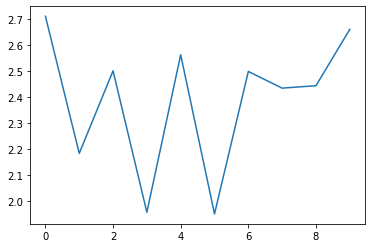

In [7]:
plt.plot(list(range(len(losses))), losses)

Testing functionality

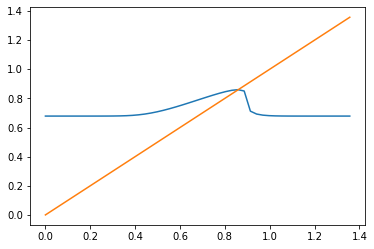

In [8]:
etas = np.array([0.5, 0.5]).reshape(1, 2)
gammas = np.array([[10., 10.]]).reshape(1, 2)
beta = np.array([np.sin(0.5), np.cos(0.5)]).reshape(2, 1)
min_score, max_score = compute_score_bounds(beta)
thresholds = np.linspace(min_score, max_score, 50)
sigma = compute_min_noise(gammas)

best_responses = [agent_best_response_mapping(beta, s, etas[0], gammas[0], sigma) for s in thresholds]

scores = [np.matmul(np.transpose(beta), x) for x in best_responses]
plt.plot(thresholds, scores)
plt.plot(thresholds, thresholds)

In [9]:
thetas = np.linspace(0., 2 * np.pi, 10)
fp = []
for theta in thetas:
    beta = np.array([np.sin(theta), np.cos(theta)])
    score_bounds_beta = compute_score_bounds(beta)

    fp.append(quantile_fixed_point(beta, etas, gammas, sigma, score_bounds_beta, 0.5))
    
plt.plot(thetas, fp)

IndexError: index 618 is out of bounds for axis 0 with size 50